In [1]:
import numpy as np
import pandas as pd
import pathlib as pl
import os 

#machine learning libraries
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.kernel_ridge import KernelRidge
from sklearn import tree, ensemble
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

#plotting function
import seaborn as sns
import matplotlib.pyplot as plt


import copy
import time


## Overview

This notebooks runs two classifier on the customer satisfaction data - Random Forest and AdaBoost from scikit learn library. With manual tweaking of hyperparameters, it is found that both models perform similarly. The overall Recall for both models is above 70%, however this is at the expense of many false positives. As a result the F1 score of both models is a bit lower than 19%. 

### Import Data

The files are available from Kaggle (https://www.kaggle.com/competitions/santander-customer-satisfaction/data)

This notebook uses 'train.csv' to train and validate models. The file 'test.csv' does not have Target value provided and thus cannot be used in the ultimate evaluation. It is loaded nonetheless.

In [2]:
path_csv = pl.Path(os.getcwd()) / f'train.csv'
with open(path_csv, 'rb') as file:
    df_train = pd.read_csv(file)

path_csv = pl.Path(os.getcwd()) / f'test.csv'
with open(path_csv, 'rb') as file:
    df_test = pd.read_csv(file)
    


In [3]:
df_test.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40532.10
1,5,2,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45486.72
2,6,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46993.95
3,7,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,187898.61
4,9,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73649.73


### Data Inspection and Pre-processing

Checking for missing data

In [4]:
#list the columns and info

df_train.info(verbose=True, null_counts=True) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Data columns (total 371 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             76020 non-null  int64  
 1   var3                           76020 non-null  int64  
 2   var15                          76020 non-null  int64  
 3   imp_ent_var16_ult1             76020 non-null  float64
 4   imp_op_var39_comer_ult1        76020 non-null  float64
 5   imp_op_var39_comer_ult3        76020 non-null  float64
 6   imp_op_var40_comer_ult1        76020 non-null  float64
 7   imp_op_var40_comer_ult3        76020 non-null  float64
 8   imp_op_var40_efect_ult1        76020 non-null  float64
 9   imp_op_var40_efect_ult3        76020 non-null  float64
 10  imp_op_var40_ult1              76020 non-null  float64
 11  imp_op_var41_comer_ult1        76020 non-null  float64
 12  imp_op_var41_comer_ult3        76020 non-null

In [5]:
#list the columns and info

df_test.info(verbose=True, null_counts=True) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75818 entries, 0 to 75817
Data columns (total 370 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             75818 non-null  int64  
 1   var3                           75818 non-null  int64  
 2   var15                          75818 non-null  int64  
 3   imp_ent_var16_ult1             75818 non-null  float64
 4   imp_op_var39_comer_ult1        75818 non-null  float64
 5   imp_op_var39_comer_ult3        75818 non-null  float64
 6   imp_op_var40_comer_ult1        75818 non-null  float64
 7   imp_op_var40_comer_ult3        75818 non-null  float64
 8   imp_op_var40_efect_ult1        75818 non-null  float64
 9   imp_op_var40_efect_ult3        75818 non-null  float64
 10  imp_op_var40_ult1              75818 non-null  float64
 11  imp_op_var41_comer_ult1        75818 non-null  float64
 12  imp_op_var41_comer_ult3        75818 non-null

In [6]:
#double check the number of missing values in training and test datasets
print("Number of null values in train and test dataset are: ", df_train.isnull().sum().sum() , "and" , df_test.isnull().sum().sum())

Number of null values in train and test dataset are:  0 and 0


Review data

Scale of features is very vast. The data is also sparse (several variables have the same value of 25 - 75 percentiles. This is addressed through scaling (Standard Scaler or Max Absolute Scaler). 

In [7]:
df_train.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


#### Inspect Target Variable

The Target variable is binary (0/1), with 1 indcating a dis-satistifed customer. The data is imbalanced, with 96% of Target value equal to 0. To address this, undersampling is used to create a training set that has equal proportion of 0/1 observations.

In [8]:
#Fraction of yes/no counts in Target. There are approximate 4% dis-satisfied customers in this dataset

df_train["TARGET"].value_counts(normalize = True)


0    0.960431
1    0.039569
Name: TARGET, dtype: float64

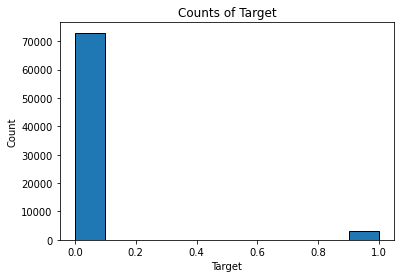

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.hist(df_train["TARGET"], edgecolor = 'k'); 
plt.xlabel('Target'); plt.ylabel('Count'); plt.title('Counts of Target');

#### Drop columns with zero values

In [10]:
#Remove columns with no data; also remove ID column

for i in df_train.columns:
    if df_train[i].sum() == 0:
        print(i)
        df_train.drop(i, inplace = True, axis = 1)
        df_test.drop(i, inplace = True, axis = 1)

df_test.drop('ID', inplace = True, axis = 1)
df_train.drop('ID', inplace = True, axis = 1)

ind_var2_0
ind_var2
ind_var27_0
ind_var28_0
ind_var28
ind_var27
ind_var41
ind_var46_0
ind_var46
num_var27_0
num_var28_0
num_var28
num_var27
num_var41
num_var46_0
num_var46
saldo_var28
saldo_var27
saldo_var41
saldo_var46
imp_amort_var18_hace3
imp_amort_var34_hace3
imp_reemb_var13_hace3
imp_reemb_var33_hace3
imp_trasp_var17_out_hace3
imp_trasp_var33_out_hace3
num_var2_0_ult1
num_var2_ult1
num_reemb_var13_hace3
num_reemb_var33_hace3
num_trasp_var17_out_hace3
num_trasp_var33_out_hace3
saldo_var2_ult1
saldo_medio_var13_medio_hace3


In [11]:
print("The number of rows and columns in train and test dataset",df_train.shape , df_test.shape )

The number of rows and columns in train and test dataset (76020, 336) (75818, 335)


#### Normalize Data

In [12]:
y = df_train['TARGET']

In [13]:
# Standardise the predictors to Normal(0,1), not the Target variable as we keep the binary structure

scaler = StandardScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train.iloc[:,:-1]),columns = df_train.columns[:-1]) #scale the predictors
df_train['TARGET'] = y

In [14]:
#check how the scaled data looks like

df_train.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,0.039074,-0.788249,-0.053388,-0.213263,-0.218813,-0.038206,-0.042103,-0.013493,-0.015538,-0.033177,...,-0.017408,-0.011979,-0.015597,-0.016314,-0.01565,-0.012576,-0.018817,-0.019847,-0.427183,0
1,0.039074,0.060753,-0.053388,-0.213263,-0.218813,-0.038206,-0.042103,-0.013493,-0.015538,-0.033177,...,-0.017408,-0.011979,-0.015597,-0.016314,-0.01565,-0.012576,-0.018817,-0.019847,-0.372038,0
2,0.039074,-0.788249,-0.053388,-0.213263,-0.218813,-0.038206,-0.042103,-0.013493,-0.015538,-0.033177,...,-0.017408,-0.011979,-0.015597,-0.016314,-0.01565,-0.012576,-0.018817,-0.019847,-0.273191,0
3,0.039074,0.292298,-0.053388,0.361427,0.138158,-0.038206,-0.042103,-0.013493,-0.015538,-0.033177,...,-0.017408,-0.011979,-0.015597,-0.016314,-0.01565,-0.012576,-0.018817,-0.019847,-0.291398,0
4,0.039074,0.446662,-0.053388,-0.213263,-0.218813,-0.038206,-0.042103,-0.013493,-0.015538,-0.033177,...,-0.017408,-0.011979,-0.015597,-0.016314,-0.01565,-0.012576,-0.018817,-0.019847,0.000412,0


#### Create Training and Validation Sets

##### Create balanced dataset with equal number of 1/0 (Yes/No) Target Variables for training. The validation dataset preserves the proportion of 1/0 (Yes/No) values seen in the original data

In [15]:
setA = df_train[df_train['TARGET']==1]
setB = df_train[df_train['TARGET']!=1]

# randomly select 50% of training samples in set A

setA_train, setA_validation = sklearn.model_selection.train_test_split(setA, 
                                                                       test_size=0.5, shuffle=True, random_state=1)
setB_train, setB_validation = sklearn.model_selection.train_test_split(setB, 
                                                                       test_size= 1-len(setA_train)/len(setB), shuffle=True, random_state=1)
#ensure equal number of yes(1)/no(0) Target observations
train = pd.concat([setA_train,setB_train],ignore_index=False)

#ensure proporation of yes(1) Target is same as in original dataset
validation = pd.concat([setA_validation,setB_validation[:int((len(setA_validation)* len(setB))/len(setA))]],ignore_index=False)



In [16]:
print('Proportion of data "yes" values in train ' ,sum(train['TARGET']==1)/len(train['TARGET']))
print('Proportion of data "yes" values in val ' ,sum(validation['TARGET']==1)/len(validation['TARGET']))

Proportion of data "yes" values in train  0.5
Proportion of data "yes" values in val  0.0395685345961589


##### X, Y DataFrames for training and val sets

In [17]:

y_train = train['TARGET']
y_val = validation['TARGET']

X_train = train.drop('TARGET', inplace = False, axis = 1)
X_val = validation.drop('TARGET', inplace = False, axis = 1)


##### Function for pre-prepossing and output training and validation sets

In [18]:
def preprocess(Scaler, RandomState):
    
    #Note: Set RandomState = None or an integer to control random sampling
    
    #load files
    path_csv = pl.Path(os.getcwd()) / f'train.csv'
    with open(path_csv, 'rb') as file:
        df_train = pd.read_csv(file)
    
    path_csv = pl.Path(os.getcwd()) / f'test.csv'
    with open(path_csv, 'rb') as file:
        df_test = pd.read_csv(file)
    
    #remove unnecessary data
    for i in df_train.columns:
        if df_train[i].sum() == 0:
            df_train.drop(i, inplace = True, axis = 1)
            df_test.drop(i, inplace = True, axis = 1)

    df_test.drop('ID', inplace = True, axis = 1)
    df_train.drop('ID', inplace = True, axis = 1)
    
    #Scaling
    y = df_train['TARGET']
    scaler = Scaler
    df_train = pd.DataFrame(scaler.fit_transform(df_train.iloc[:,:-1]),columns = df_train.columns[:-1]) #scale the predictors
    df_train['TARGET'] = y
    
    #train val split
    setA = df_train[df_train['TARGET']==1]
    setB = df_train[df_train['TARGET']!=1]

        # randomly select 50% of training samples in set A

    setA_train, setA_validation = sklearn.model_selection.train_test_split(setA, 
                                                                       test_size=0.5, shuffle=True, random_state=RandomState)  
    setB_train, setB_validation = sklearn.model_selection.train_test_split(setB, 
                                                                       test_size= 1-len(setA_train)/len(setB), shuffle=True, random_state=RandomState)
        #ensure equal number of yes(1)/no(0) Target observations
    train = pd.concat([setA_train,setB_train],ignore_index=False)

        #ensure proporation of yes(1) Target is same as in original dataset
    validation = pd.concat([setA_validation,setB_validation[:int((len(setA_validation)* len(setB))/len(setA))]],ignore_index=False)

    y_train = train['TARGET']
    y_val = validation['TARGET']

    X_train = train.drop('TARGET', inplace = False, axis = 1)
    X_val = validation.drop('TARGET', inplace = False, axis = 1)
    
    return Scaler, y_train, X_train, y_val, X_val

       

    

# Specify and Fit Models to Data

## Random Forest

Looking at results of other participants, Random Forest performs rather well for this problem and we explore if the results match and can be improved.

In [19]:
rf_clf = ensemble.RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

### Model Run Tools

#### Evaluation functions

In [20]:
def precision(y_true,y_pred):
    ## The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
    from sklearn.metrics import confusion_matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    tp = conf_matrix[1,1]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    fn = conf_matrix[1,0]
    a = tp / (tp + fp)
    return round(a,4)

def recall(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    tp = conf_matrix[1,1]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    fn = conf_matrix[1,0]
    a = tp / (tp + fn)
    return round(a,4)

def f1Score(y_true, y_pred):
    # The harmonic mean of precision and recall. An F1 score of 0.7 indicates that the model is fairly good at identifying positive cases without labeling too many false positives or missing too many actual positives.
    from sklearn.metrics import confusion_matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    tp = conf_matrix[1,1]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    fn = conf_matrix[1,0]
    a = (2*tp) / (2*tp + fp+ fn)
    return round(a,4)

def accuracy(y_true,y_pred):
    # The proportion of true results among the total number of cases examined.
    from sklearn.metrics import confusion_matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    tp = conf_matrix[1,1]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    fn = conf_matrix[1,0]
    a = (tp + tn) / (tp + fp + fn + tn)
    return round(a,4)



#### Generic model run and evaluation function

In [21]:
def modelRun(model,X_train, y_train, X_val, y_val):
    current = model()
    current.fit(X_train, y_train)
    y_pred_train = current.predict(X_train)
    y_pred_val = current.predict(X_val)
    return model, precision(y_train, y_pred_train), recall(y_train, y_pred_train), f1Score(y_train, y_pred_train), precision(y_val, y_pred_val), recall(y_val, y_pred_val), f1Score(y_val, y_pred_val)


## Random Forest

In [22]:
model = ensemble.RandomForestClassifier(max_features='sqrt')
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
out = model, precision(y_train, y_train_pred), recall(y_train, y_train_pred), f1Score(y_train, y_train_pred), precision(y_val, y_val_pred), recall(y_val, y_val_pred), f1Score(y_val,y_val_pred)

out


(RandomForestClassifier(max_features='sqrt'),
 0.99,
 0.988,
 0.989,
 0.1067,
 0.7281,
 0.1862)

Random forest does not generalise well to validation set. The recall of predicted true positive is high, however the number of false positives is very high and would thus make the model less practical in real life.

        No   Yes
No   27343  9163
Yes    409  1095


Text(33.0, 0.5, 'True Value')

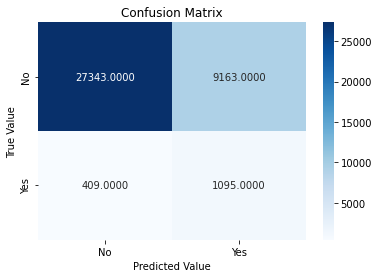

In [23]:
cf_matrix = confusion_matrix(y_val, y_val_pred)#, normalize='true')

plt.title('Confusion Matrix')
cf = pd.DataFrame(data = cf_matrix, columns = ['No', 'Yes'], index = ['No', 'Yes'])
print(cf)
sns.heatmap(cf, annot=True, fmt='.4f', cmap='Blues')

plt.xlabel('Predicted Value')
plt.ylabel('True Value')



#### Feature Selection in Random Forests

In [24]:
feature_importances = rf_clf.feature_importances_
sorted_idx = feature_importances.argsort()
feature_names = X_train.columns

In [25]:
def plot_impurity_metric_features( feature_importances, sorted_idx, feature_names):
    y_ticks = np.arange(0, len(feature_names))
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.barh(y_ticks, feature_importances[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_title("Random Forest Feature Importances (MDI)")
    fig.tight_layout()
    plt.show()

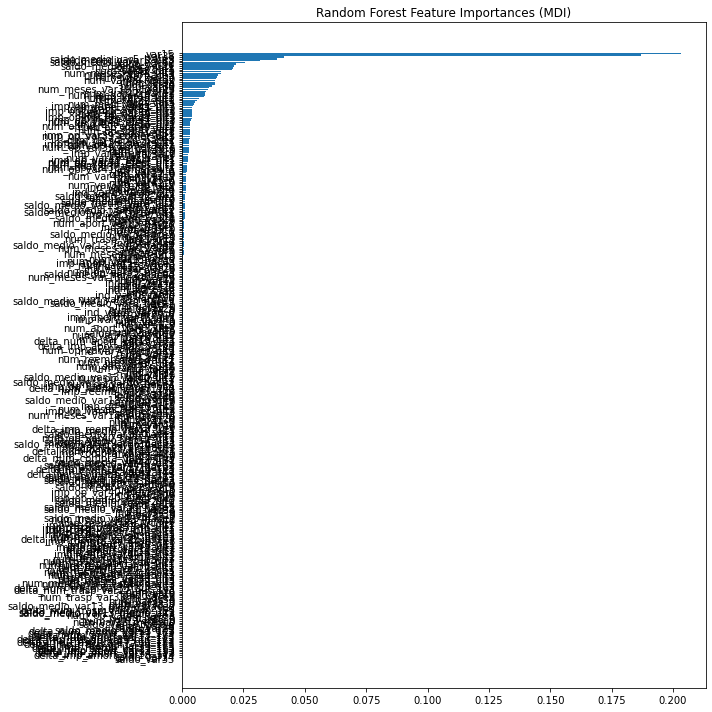

In [26]:
# impurity metric based approach on training

plot_impurity_metric_features( feature_importances, sorted_idx, feature_names)

In [27]:
# Top 10 features

sorted_idx = feature_importances.argsort()[0:10]
feature_names = X_train.columns[sorted_idx]
feature_names



Index(['saldo_var33', 'saldo_var34', 'delta_imp_amort_var18_1y3',
       'delta_imp_amort_var34_1y3', 'delta_imp_aport_var17_1y3',
       'delta_imp_aport_var33_1y3', 'delta_imp_reemb_var17_1y3',
       'delta_imp_reemb_var33_1y3', 'delta_imp_trasp_var17_in_1y3',
       'delta_imp_trasp_var17_out_1y3'],
      dtype='object')

In [28]:
newData = preprocess(MaxAbsScaler(),1)

scaling = newData[0]
y_train = newData[1]
X_train = newData[2]
y_val = newData[3]
X_val = newData[4]

In [29]:
model = ensemble.RandomForestClassifier(max_features='sqrt')
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

out = scaling, model, precision(y_train, y_train_pred), recall(y_train, y_train_pred), f1Score(y_train, y_train_pred), precision(y_val, y_val_pred), recall(y_val, y_val_pred), f1Score(y_val,y_val_pred)

out

(MaxAbsScaler(),
 RandomForestClassifier(max_features='sqrt'),
 0.9867,
 0.9847,
 0.9857,
 0.1058,
 0.7207,
 0.1845)

In [30]:
results = pd.DataFrame(columns=['Scaling','Model','Precision_tr','Recall_tr','F1 Score_tr','Precision_val','Recall_val','F1 Score_val'])

In [31]:
results.loc[len(results)] = out
results

,Scaling,Model,Precision_tr,Recall_tr,F1 Score_tr,Precision_val,Recall_val,F1 Score_val
0,MaxAbsScaler(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.9867,0.9847,0.9857,0.1058,0.7207,0.1845


## Boosting Classifier

Test scikit learn's AdaBoost based on J. Zhu, H. Zou, S. Rosset, T. Hastie, “Multi-class adaboost.” Statistics and its Interface 2.3 (2009): 349-360. 

"The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction."

While the model fits training data well, it suffers from the low F1 score, similar to the RF classifier. This is because of large number of False Positives.  Interestingly the top 5 important features from both classifier are the same but their order is different.

In [32]:
newData = preprocess(MaxAbsScaler(),1)

scaling = newData[0]
y_train = newData[1]
X_train = newData[2]
y_val = newData[3]
X_val = newData[4]

In [33]:
model = ensemble.AdaBoostClassifier(algorithm='SAMME.R', n_estimators=100, random_state=0)
model.fit(X_train, y_train)

modelName = "AdaBoostClassifier SAMME_R, n_estimators=100, random_state=0"

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

out = scaling, modelName, precision(y_train, y_train_pred), recall(y_train, y_train_pred), f1Score(y_train, y_train_pred), precision(y_val, y_val_pred), recall(y_val, y_val_pred), f1Score(y_val,y_val_pred)

out

(MaxAbsScaler(),
 'AdaBoostClassifier SAMME_R, n_estimators=100, random_state=0',
 0.7855,
 0.7985,
 0.792,
 0.1063,
 0.7633,
 0.1865)

In [34]:
results.loc[1] = out
results

,Scaling,Model,Precision_tr,Recall_tr,F1 Score_tr,Precision_val,Recall_val,F1 Score_val
0,MaxAbsScaler(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.9867,0.9847,0.9857,0.1058,0.7207,0.1845
1,MaxAbsScaler(),"AdaBoostClassifier SAMME_R, n_estimators=100, ...",0.7855,0.7985,0.7920,0.1063,0.7633,0.1865


In [35]:
feature_importances = model.feature_importances_
sorted_idx = feature_importances.argsort()
feature_names = X_train.columns

In [36]:
# Top 10 features

sorted_idx = feature_importances.argsort()[0:10]
feature_names = X_train.columns[sorted_idx]
feature_names



Index(['saldo_var33', 'imp_var7_emit_ult1', 'imp_aport_var33_ult1',
       'imp_aport_var33_hace3', 'imp_aport_var17_ult1',
       'imp_aport_var17_hace3', 'imp_aport_var13_ult1', 'imp_var7_recib_ult1',
       'imp_amort_var34_ult1', 'delta_num_venta_var44_1y3'],
      dtype='object')